# `contextily`

In [2]:
%matplotlib inline

import contextily as ctx
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Data
from pysal.examples import get_path

* Load polygon

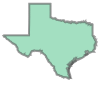

In [27]:
tx = gpd.read_file(get_path('us48.shp')).set_index('STATE_ABBR').loc[['TX'], 'geometry']
tx.crs = {'init': 'epsg:4326'}
tx['TX']

In [28]:
w, s, e, n = tx['TX'].bounds

## Download tiles

* Check appropriate zoom

In [12]:
_ = ctx.howmany(w, s, e, n, 7)

Using zoom level 7, this will download 25 tiles


* Download tiles to contextualize `tx`

In [35]:
%time img, ext = ctx.bounds2img(w, s, e, n, 7)

CPU times: user 68 ms, sys: 16 ms, total: 84 ms
Wall time: 10.6 s


* Quick plotting

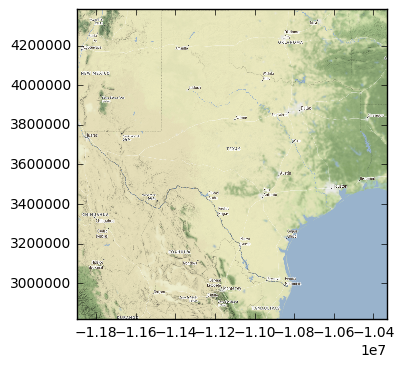

In [41]:
plt.imshow(img, extent=ext);

## Save tiles into raster files

* Download same image as above into a more detailed one (higher zoom) and save into a `GeoTiff`

In [72]:
_ = ctx.howmany(w, s, e, n, 9)

Using zoom level 9, this will download 360 tiles


In [73]:
%time _ = ctx.bounds2raster(w, s, e, n, 9, 'tx.tif')

CPU times: user 2.7 s, sys: 288 ms, total: 2.99 s
Wall time: 6min 10s


## Read raster tiles and combine with vector data

* Full raster with `rasterio`

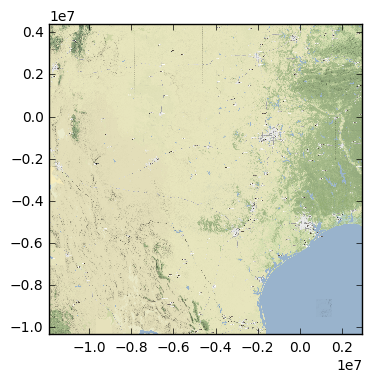

In [128]:
rtr = rio.open('tx.tif')

# NOTE the transpose of the image data
img = np.array([ band for band in rtr.read() ]).transpose(1, 2, 0)
# Plot
plt.imshow(img, extent=rtr.bounds);

* Window into a section of the raster (does not read the entire one)

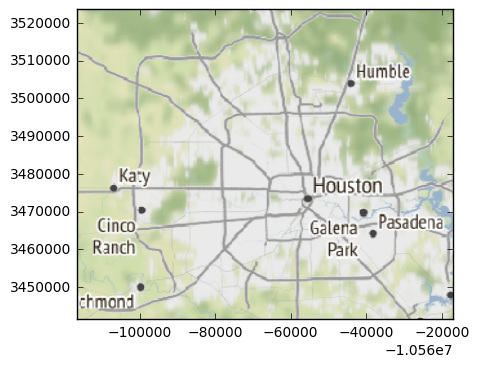

In [127]:
hou = (-10676650.69219051, 3441477.046670125, -10576977.7804825, 3523606.146650609)

# Window
wdw = ctx.ll2wdw(hou, rtr)
# Raster subset
sub = np.array([ rtr.read(band, window=wdw) \
      for band in range(1, rtr.count+1)]).transpose(1, 2, 0)
# Plot
plt.imshow(sub, extent=(hou[0], hou[2], hou[1], hou[3]));

## Combine layers

* Full extent

In [80]:
w, s, e, n = tx['TX'].bounds
%time img, ext = ctx.bounds2img(w, s, e, n, 6)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 3.35 s


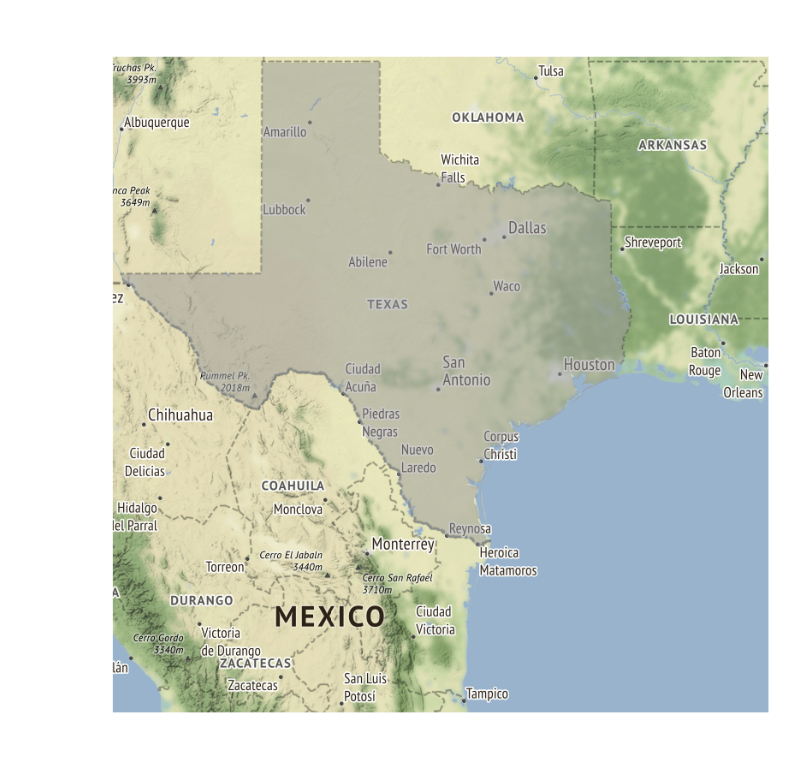

In [83]:
f, ax = plt.subplots(1, figsize=(9, 9))
bb = rtr.bounds
ax.imshow(img, extent=ext)
tx.to_crs(rtr.crs).plot(edgecolor='none', ax=ax)
ax.set_axis_off()
plt.show()